# 1) Environment & repo sanity

In [1]:
# Run this from repo root or from /notebooks (it will hop to root automatically)
import os, sys, subprocess, shutil, json
from pathlib import Path
import torch

# Move to repo root if we're inside notebooks/
if Path.cwd().name == "notebooks":
    os.chdir("..")
print("CWD:", Path.cwd())

# Make src importable
if not Path("src").exists():
    raise RuntimeError("I can't find src/. Run this notebook from the project repo (idrid-sr-zsl).")

# Quick CUDA check
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Create outputs dirs
Path("outputs/sr_models").mkdir(parents=True, exist_ok=True)
Path("outputs/sr_images").mkdir(parents=True, exist_ok=True)
Path("outputs/metrics").mkdir(parents=True, exist_ok=True)
Path("outputs/demos").mkdir(parents=True, exist_ok=True)


CWD: c:\Users\Jonathan Morel\Desktop\Honour
Torch: 2.10.0.dev20250910+cu128 | CUDA available: True
GPU: NVIDIA GeForce RTX 5070


# 2) Load config & verify dataset paths

In [2]:
from src.config.loader import load_cfg
from pathlib import Path
cfg = load_cfg("config.yaml")   # or "config_colab.yaml" if you're on Colab

print("Resolved paths:")
for k,v in cfg.paths.items():
    if isinstance(v, str):
        print(f"  {k:28s} -> {v}")

print("\nExistence checks:")
must_keys = [
    "grading_images","grading_labels",
    "segmentation_images","masks_root"
]
for k in must_keys:
    p = Path(cfg.paths[k])
    print(f"{k:20s}: {p} | exists={p.exists()}")


Resolved paths:


AttributeError: 'types.SimpleNamespace' object has no attribute 'items'

# 3) Peek at the data (counts + one overlay)

Grading images total     : 516
Segmentation images total: 81
Mask IDs (should be ~81) : 81


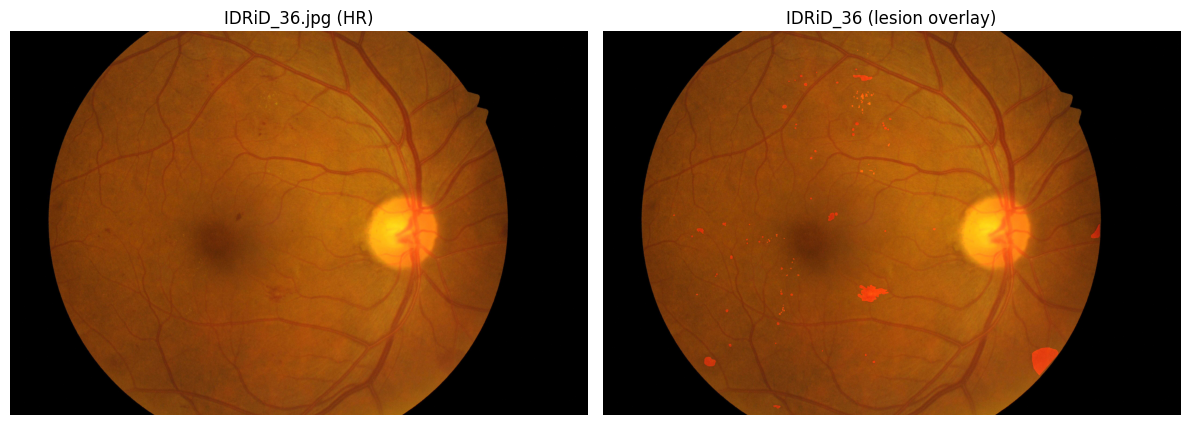

Masks present for sample: ['EX', 'HE', 'MA', 'OD']


In [3]:
# === 3) Peek at the data (counts + one lesion overlay) ===
from src.utils.paths import list_images
from src.datasets.segmentation import list_mask_image_ids, load_masks_for_id, union_mask
from src.utils.viz import overlay_mask_rgb
from PIL import Image
import numpy as np, random, matplotlib.pyplot as plt
from pathlib import Path as P

# Counts (recursive under a./b. Training/Testing)
grading_imgs = list_images(cfg.paths["grading_images"], recursive=True)
seg_imgs     = list_images(cfg.paths["segmentation_images"], recursive=True)
mask_ids     = list_mask_image_ids(cfg.paths["masks_root"])

print(f"Grading images total     : {len(grading_imgs)}")   # ~516
print(f"Segmentation images total: {len(seg_imgs)}")       # 81
print(f"Mask IDs (should be ~81) : {len(mask_ids)}")

def find_seg_hr_for_id(img_id: str):
    """Find the HR segmentation image path for a given base ID (IDRiD_01)."""
    roots = [
        P(cfg.paths["segmentation_images"]) / "a. Training Set",
        P(cfg.paths["segmentation_images"]) / "b. Testing Set",
        P(cfg.paths["segmentation_images"])  # fallback if images aren't in a./b.
    ]
    for r in roots:
        for ext in (".jpg",".jpeg",".png",".tif",".tiff",".bmp"):
            p = r / f"{img_id}{ext}"
            if p.exists():
                return p
    # relax: allow files that *start with* the id (to handle odd padding)
    for r in roots:
        for p in r.glob(f"{img_id}*"):
            if p.is_file():
                return p
    return None

# If we have masks, show an overlay; else show a plain segmentation image
if len(mask_ids) == 0:
    print("\n[WARN] No masks found under masks_root; showing a random segmentation image only.")
    hr_path = P(random.choice(seg_imgs))
    img = np.array(Image.open(hr_path).convert("RGB"), dtype=np.float32)/255.0
    plt.figure(figsize=(6,6)); plt.imshow(img); plt.title(f"{hr_path.name} (HR only)"); plt.axis("off"); plt.show()
else:
    sample_id = random.choice(mask_ids)
    hr_path = find_seg_hr_for_id(sample_id)
    if hr_path is None:
        # fallback to any seg image if exact match doesn't exist (should be rare)
        print(f"[WARN] Could not find HR image for {sample_id}; showing a random one.")
        hr_path = P(random.choice(seg_imgs))
    img = np.array(Image.open(hr_path).convert("RGB"), dtype=np.float32)/255.0
    masks = load_masks_for_id(cfg.paths["masks_root"], sample_id)  # dict of lesion masks
    u = union_mask(masks, shape=img)                               # union of MA/HE/EX/SE
    vis = overlay_mask_rgb(img, u)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(img); plt.title(f"{hr_path.name} (HR)"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(vis); plt.title(f"{sample_id} (lesion overlay)"); plt.axis("off")
    plt.tight_layout(); plt.show()
    print("Masks present for sample:", sorted(list(masks.keys())))


# 4) Quick SR single-image demo (bicubic + SRCNN if checkpoint exists)

In [4]:
# === 4) Quick SR demo (bicubic vs SRCNN) ===
import cv2, numpy as np, torch, random, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

from src.models.sr import build_sr

# make sure Section 3 ran
assert len(grading_imgs) > 0, "Run Section 3 first to populate `grading_imgs`."

# pick one grading image for demo
demo_img = random.choice(grading_imgs)
hr = np.array(Image.open(demo_img).convert("RGB"), dtype=np.float32) / 255.0
h, w = hr.shape[:2]

scale = int(cfg.sr["scale"])
lr = cv2.resize(hr, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)
lr_up = cv2.resize(lr, (w, h), interpolation=cv2.INTER_CUBIC)

# Bicubic baseline
bic = lr_up

# Try SRCNN if a checkpoint exists
sr_srcnn = None
ckpt = Path("outputs/sr_models/srcnn_best.pt")
if ckpt.exists():
    # Build model wrapper
    sr_model = build_sr("srcnn", device=cfg.run["device"], cfg=cfg)

    # Load checkpoint supporting both {"model": state_dict} and raw state_dict
    sd = torch.load(ckpt, map_location=cfg.run["device"])
    state = sd.get("model", sd)

    # Load into the underlying nn.Module
    if hasattr(sr_model, "module"):
        sr_model.module.load_state_dict(state)
    else:
        # if the wrapper itself is an nn.Module (fallback)
        try:
            sr_model.load_state_dict(state)
        except Exception as e:
            raise RuntimeError(f"Couldn't load checkpoint into SRCNN: {e}")

    sr_model.eval_mode()

    # Inference
    x = torch.from_numpy(lr_up.transpose(2,0,1)).unsqueeze(0).float().to(cfg.run["device"])
    with torch.no_grad():
        y = sr_model.forward_tensor(x).clamp(0,1).cpu().squeeze(0).numpy().transpose(1,2,0)
    sr_srcnn = y
else:
    print("No SRCNN checkpoint yet. Train in Section 6 first.")

# Show side-by-side
tiles = [
    (hr, "HR (original)"),
    (bic, "Bicubic (x2)"),
    (sr_srcnn if sr_srcnn is not None else bic,
     "SRCNN (x2)" if sr_srcnn is not None else "SRCNN (missing) → Bicubic")
]
plt.figure(figsize=(14,4))
for i, (im, ttl) in enumerate(tiles, start=1):
    plt.subplot(1,3,i); plt.imshow(np.clip(im,0,1)); plt.title(ttl); plt.axis("off")
plt.tight_layout(); plt.show()

print("Demo image:", demo_img)


AttributeError: 'function' object has no attribute 'load_state_dict'

In [ ]:
# helper to get the underlying nn.Module from any SR wrapper
def get_base_module(sr_model):
    m = getattr(sr_model, "module", None)
    if m is None:
        # maybe the wrapper itself is the nn.Module
        return sr_model if hasattr(sr_model, "parameters") else None
    return m() if callable(m) else m


In [ ]:
from pathlib import Path

keys_to_check = [
    "grading_images", "grading_labels",
    "segmentation_images", "masks_root",
    "localization_images", "localization_labels"
]
print("Existence checks:\n")
for k in keys_to_check:
    p = Path(cfg.paths.get(k, ""))
    print(f"{k:22s}: {p} | exists={p.exists()}")

grading_imgs = list_images(cfg.paths["grading_images"], recursive=True)
seg_imgs     = list_images(cfg.paths["segmentation_images"], recursive=True)

print("\nCounts:")
print("  grading images total     :", len(grading_imgs))     # expect ~516
print("  segmentation images total:", len(seg_imgs))         # expect 81


Existence checks:

grading_images        : C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images | exists=True
grading_labels        : C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\2. Groundtruths\a. IDRiD_Disease Grading_Training Labels.csv | exists=True
segmentation_images   : C:\Users\Jonathan Morel\Desktop\Honour\Data\A. Segmentation\1. Original Images | exists=True
masks_root            : C:\Users\Jonathan Morel\Desktop\Honour\Data\A. Segmentation\2. All Segmentation Groundtruths | exists=True
localization_images   : C:\Users\Jonathan Morel\Desktop\Honour\Data\C. Localization\1. Original Images | exists=True
localization_labels   : C:\Users\Jonathan Morel\Desktop\Honour\Data\C. Localization\2. Groundtruths | exists=True

Counts:
  grading images total     : 516
  segmentation images total: 81


In [ ]:
# If your project root isn't already on sys.path, add it:
import sys, os
PROJECT_ROOT = os.path.abspath(".")  # or the folder containing your "src"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.config.loader import load_cfg

cfg = load_cfg("config.yaml")
print("Loaded config. Key paths:")
for k,v in cfg.paths.items():
    if isinstance(v, str):
        print(f"{k:26s} -> {v}")

# Ensure list_images supports `recursive=`
from inspect import signature
from src.utils import paths as paths_mod

if "recursive" not in signature(paths_mod.list_images).parameters:
    # Hotfix wrapper if your local version doesn't accept `recursive`
    from pathlib import Path
    def _list_images(folder, exts=(".jpg",".jpeg",".png",".tif",".tiff",".bmp"), recursive=True):
        p = Path(folder)
        it = p.rglob("*") if recursive else p.glob("*")
        return sorted([str(fp) for fp in it if fp.suffix.lower() in exts])
    paths_mod.list_images = _list_images

from src.utils.paths import list_images, ensure_dir


Loaded config. Key paths:
root                       -> C:\Users\Jonathan Morel\Desktop\Honour\Data
grading_images             -> C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images
grading_images_train       -> C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images\a. Training Set
grading_images_test        -> C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images\b. Testing Set
grading_labels             -> C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\2. Groundtruths\a. IDRiD_Disease Grading_Training Labels.csv
grading_labels_train       -> C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\2. Groundtruths\a. IDRiD_Disease Grading_Training Labels.csv
grading_labels_test        -> C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\2. Groundtruths\b. IDRiD_Disease Grading_Testing Labels.csv
segmentation_images        -> C:\Users\Jonathan Morel\Desktop\Honour\Dat

In [ ]:
import sys, subprocess, platform, os
import torch

print("Python:", sys.version)
print("OS:", platform.platform())
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("Compute capability:", torch.cuda.get_device_capability(0))
    print("CUDA (built):", torch.version.cuda)
    print("cuDNN:", torch.backends.cudnn.version())

# Live GPU stats (if nvidia-smi on PATH)
try:
    out = subprocess.check_output(
        ["nvidia-smi","--query-gpu=name,driver_version,utilization.gpu,memory.used,memory.total","--format=csv,noheader,nounits"]
    ).decode().strip()
    print("\nNVIDIA-SMI:\n", out)
except Exception as e:
    print("\n(nvidia-smi not available)", e)


Python: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
OS: Windows-11-10.0.26100-SP0
Torch: 2.10.0.dev20250910+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 5070
Compute capability: (12, 0)
CUDA (built): 12.8
cuDNN: 91002

NVIDIA-SMI:
 NVIDIA GeForce RTX 5070, 581.15, 1, 1131, 12227


In [ ]:
import torch

print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Compiled with CUDA?", torch.version.cuda is not None)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("Compute capability:", torch.cuda.get_device_capability(0))


Torch version: 2.10.0.dev20250910+cu128
CUDA version: 12.8
Compiled with CUDA? True
CUDA available: True
GPU: NVIDIA GeForce RTX 5070
Compute capability: (12, 0)


In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_capability(0))


True
NVIDIA GeForce RTX 5070
(12, 0)


In [ ]:
import torch
from src.models.sr import build_sr

device = "cuda"
model = build_sr("srcnn", device=device, cfg=cfg)  # swap "fsrcnn" if you like

# dummy low-res-upsampled patch
x = torch.randn(1, 3, 256, 256, device=device).to(memory_format=torch.channels_last)

# forward
model.eval_mode()
with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
    y = model.forward_tensor(x).clamp(0,1)
print("Forward OK:", y.shape, y.dtype)


Forward OK: torch.Size([1, 3, 256, 256]) torch.float16


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_31072\2935298048.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


In [ ]:
# === FAST SR TRAINING (precomputed patches + AMP + channels_last + OOM fixes) ===
import re, random, time, numpy as np, torch, platform
from pathlib import Path
from PIL import Image
import torch.nn.functional as F
from src.utils.paths import list_images, ensure_dir
import src.datasets.segmentation as seg
from src.models.sr import build_sr
from torch import amp

# ---- speed knobs ----
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")
# New TF32 flags (replace old allow_tf32)
torch.backends.cuda.matmul.fp32_precision = "tf32"
torch.backends.cudnn.conv.fp32_precision = "tf32"

# ---- config ----
MODEL      = "srcnn"              # "srcnn" or "fsrcnn"
scale      = int(cfg.sr["scale"]) # 2
patch      = int(cfg.sr["patch"]) # 256
stride     = int(cfg.sr["stride"])# 128
batch_size = 64                   # bump until VRAM says stop
epochs     = 3                    # increase later (e.g., 8–12)
lr         = float(cfg.sr["lr"])  # 1e-4
device     = cfg.run["device"]    # "cuda"
alpha      = float(cfg.sr["alpha"])
lam_s      = float(cfg.sr["lambda_ssim"])

# ---- memory knobs ----
PINNED    = True                  # False if you still OOM
HR_DTYPE  = torch.float16         # fp16 patches
MASK_DTYPE= torch.uint8           # 0/1 masks
TRAIN_MAX = 40
VAL_MAX   = 20

# ----------------- cache full images -----------------
_id_re = re.compile(r"(IDRiD_\d+)", flags=re.I)
def base_id_from_path(p: str):
    m = _id_re.search(Path(p).stem)
    return m.group(1) if m else None

seg_paths = list_images(cfg.paths["segmentation_images"], recursive=True)
imgs_cpu, masks_cpu = {}, {}
for ip in seg_paths:
    try:
        arr = np.array(Image.open(ip).convert("RGB"), dtype=np.float32)/255.0
    except Exception:
        continue
    imgs_cpu[ip] = torch.from_numpy(arr.transpose(2,0,1))  # 3xHxW
    bid = base_id_from_path(ip)
    if bid:
        ms = seg.load_masks_for_id(cfg.paths["masks_root"], bid)
        if ms:
            m = seg.union_mask(ms, shape=arr).astype(np.float32)  # HxW
            masks_cpu[ip] = torch.from_numpy(m).unsqueeze(0)      # 1xHxW

print(f"Cached images: {len(imgs_cpu)} | with masks: {len(masks_cpu)}")

# ----------------- build patch tensors -----------------
def build_patches(paths, max_per_img):
    HR_list, W_list = [], []
    for ip in paths:
        x = imgs_cpu.get(ip)
        if x is None: 
            continue
        _, H, Wimg = x.shape
        if H < patch or Wimg < patch:
            continue
        coords = [(y,x0) for y in range(0, H - patch + 1, stride)
                          for x0 in range(0, Wimg - patch + 1, stride)]
        random.shuffle(coords)
        coords = coords[:max_per_img]
        wm_full = masks_cpu.get(ip)
        for (y, x0) in coords:
            hr = x[:, y:y+patch, x0:x0+patch].contiguous().to(HR_DTYPE)
            if wm_full is not None:
                w = wm_full[:, y:y+patch, x0:x0+patch].contiguous().to(MASK_DTYPE)
            else:
                w = torch.ones(1, patch, patch, dtype=MASK_DTYPE)
            HR_list.append(hr)
            W_list.append(w)
    HR = torch.stack(HR_list).contiguous(memory_format=torch.channels_last)
    W  = torch.stack(W_list)
    if PINNED:
        try:
            HR = HR.pin_memory()
            W  = W.pin_memory()
        except RuntimeError as e:
            print("[WARN] pin_memory OOM; falling back to non-pinned.", e)
    return HR, W

random.seed(cfg.run["seed"])
seg_sorted = sorted(list(imgs_cpu.keys())); random.shuffle(seg_sorted)
train_paths = seg_sorted[:70]
val_paths   = seg_sorted[70:]

HR_tr, W_tr = build_patches(train_paths, max_per_img=TRAIN_MAX)
HR_va, W_va = build_patches(val_paths,   max_per_img=VAL_MAX)

print("Train patches:", HR_tr.shape, HR_tr.dtype, "| Val patches:", HR_va.shape, HR_va.dtype)
print("Mask dtypes  :", W_tr.dtype, W_va.dtype)

# ----------------- model (channels_last + optional compile) -----------------
def get_base_module(sr_model):
    m = getattr(sr_model, "module", None)
    if m is None: return sr_model if hasattr(sr_model, "parameters") else None
    return m() if callable(m) else m

sr_model = build_sr(MODEL, device=device, cfg=cfg)
base = get_base_module(sr_model)
assert base is not None, "Couldn't unwrap SR nn.Module from wrapper."

# move/format
base = base.to(device).to(memory_format=torch.channels_last)

# compile if possible (not supported on Windows)
if platform.system() != "Windows":
    try:
        compiled = torch.compile(base)
        base = compiled
        if hasattr(sr_model, "_m"):
            sr_model._m = base
        print("[INFO] torch.compile enabled.")
    except Exception as e:
        print("[WARN] torch.compile failed, fallback to eager:", e)
else:
    print("[INFO] Skipping torch.compile (not supported on Windows).")

opt    = torch.optim.Adam(base.parameters(), lr=lr)
scaler = amp.GradScaler("cuda") if torch.cuda.is_available() else None

# ----------------- training helpers -----------------
def ssim_like(a, b, eps=1e-6):
    mu_a = F.avg_pool2d(a, 7, 1, 3); mu_b = F.avg_pool2d(b, 7, 1, 3)
    return ((2*mu_a*mu_b + 0.01) / (mu_a**2 + mu_b**2 + 0.01 + eps)).mean()

def run_epoch(HR, W, train=True):
    sr_model.train_mode() if train else sr_model.eval_mode()
    n = HR.size(0); order = torch.randperm(n); total = 0.0
    for i in range(0, n, batch_size):
        idx = order[i:i+batch_size]
        hr = HR[idx].to(device, non_blocking=True).to(memory_format=torch.channels_last)
        wm = W[idx].to(device, non_blocking=True).float()
        with amp.autocast("cuda", enabled=torch.cuda.is_available()):
            lr_small = F.interpolate(hr, scale_factor=1/scale, mode="bicubic",
                                     align_corners=False, antialias=True)
            lr_up    = F.interpolate(lr_small, scale_factor=scale, mode="bicubic",
                                     align_corners=False)
            sr       = sr_model.forward_tensor(lr_up).clamp(0,1)
            l1       = (torch.abs(sr - hr) * (1 + alpha*wm)).mean()
            loss     = l1 - lam_s * ssim_like(sr, hr)
        if train:
            opt.zero_grad(set_to_none=True)
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                loss.backward(); opt.step()
        total += loss.detach().item()
    return total / max(1, (n + batch_size - 1)//batch_size)

# ----------------- main training loop -----------------
best = float("inf")
ensure_dir("outputs/sr_models")
ckpt_path = f"outputs/sr_models/{MODEL}_best.pt"

for ep in range(1, epochs+1):
    t0 = time.time()
    tr = run_epoch(HR_tr, W_tr, train=True)
    va = run_epoch(HR_va, W_va, train=False)
    dt = time.time()-t0
    print(f"[{MODEL.upper()} EP {ep:02d}] train={tr:.4f}  val={va:.4f}  ({dt:.1f}s)")
    if va < best:
        best = va
        torch.save({"model": base.state_dict(), "epoch": ep, "val_loss": best}, ckpt_path)
        print("  ↳ saved:", ckpt_path)


Cached images: 81 | with masks: 81
Train patches: torch.Size([2800, 3, 256, 256]) torch.float16 | Val patches: torch.Size([220, 3, 256, 256]) torch.float16
Mask dtypes  : torch.uint8 torch.uint8
[INFO] Skipping torch.compile (not supported on Windows).
[SRCNN EP 01] train=0.0428  val=-0.0638  (12.5s)
  ↳ saved: outputs/sr_models/srcnn_best.pt
[SRCNN EP 02] train=-0.0747  val=-0.0833  (3.4s)
  ↳ saved: outputs/sr_models/srcnn_best.pt
[SRCNN EP 03] train=-0.0860  val=-0.0882  (3.4s)
  ↳ saved: outputs/sr_models/srcnn_best.pt


# Full scale SR - Lesion Aware

In [ ]:
# === SEGMENTATION SR TRAINING (lesion-aware, with logging + checkpoints) ===
import os, csv, random, numpy as np, torch
from pathlib import Path
from PIL import Image
import torch.nn.functional as F
from torch import amp
from src.utils.paths import list_images, ensure_dir
import src.datasets.segmentation as seg
from src.models.sr import build_sr
from src.metrics.sr_metrics import psnr as calc_psnr, ssim as calc_ssim

# ---- config ----
MODEL, scale, patch, stride = "srcnn", 2, 256, 128
batch_size, epochs, lr = 64, 20, 1e-4   # run more epochs for better results
device = cfg.run["device"]
seed = cfg.run.get("seed", 42)

# ---- reproducibility ----
torch.manual_seed(seed); random.seed(seed); np.random.seed(seed)

# ---- cache images + masks ----
seg_paths = list_images(cfg.paths["segmentation_images"], recursive=True)
imgs_cpu, masks_cpu = {}, {}
for ip in seg_paths:
    arr = np.array(Image.open(ip).convert("RGB"), dtype=np.float32)/255.0
    imgs_cpu[ip] = torch.from_numpy(arr.transpose(2,0,1))
    bid = Path(ip).stem.split("_")[0] + "_" + Path(ip).stem.split("_")[1]
    ms = seg.load_masks_for_id(cfg.paths["masks_root"], bid)
    if ms:
        m = seg.union_mask(ms, shape=arr).astype(np.float32)
        masks_cpu[ip] = torch.from_numpy(m).unsqueeze(0)

print(f"[Segmentation] Cached images: {len(imgs_cpu)} | with masks: {len(masks_cpu)}")

# ---- build patches ----
def build_patches(imgs, max_per_img=40):
    HR_list, W_list = [], []
    for ip, x in imgs.items():
        _, H, W = x.shape
        if H < patch or W < patch:
            continue
        coords = [(y,x0) for y in range(0, H - patch + 1, stride)
                          for x0 in range(0, W - patch + 1, stride)]
        random.shuffle(coords)
        coords = coords[:max_per_img]
        wm_full = masks_cpu.get(ip)
        for (y, x0) in coords:
            hr = x[:, y:y+patch, x0:x0+patch].contiguous().to(torch.float16)
            if wm_full is not None:
                w = wm_full[:, y:y+patch, x0:x0+patch].contiguous().to(torch.uint8)
            else:
                w = torch.ones(1, patch, patch, dtype=torch.uint8)
            HR_list.append(hr); W_list.append(w)
    return torch.stack(HR_list), torch.stack(W_list)

seg_paths = list(imgs_cpu.keys())
random.shuffle(seg_paths)
train_paths, val_paths = seg_paths[:70], seg_paths[70:]
HR_tr, W_tr = build_patches({k: imgs_cpu[k] for k in train_paths}, 40)
HR_va, W_va = build_patches({k: imgs_cpu[k] for k in val_paths}, 20)

print("Train patches:", HR_tr.shape, "| Val patches:", HR_va.shape)

# ---- model unwrap ----
sr_model = build_sr(MODEL, device=device, cfg=cfg)
base = getattr(sr_model, "module", None)
if base is None and hasattr(sr_model, "parameters"):
    base = sr_model
elif callable(base):
    base = base()

opt = torch.optim.Adam(base.parameters(), lr=lr)
scaler = amp.GradScaler("cuda")

# ---- training loop ----
def run_epoch(HR, W, train=True):
    sr_model.train_mode() if train else sr_model.eval_mode()
    order, total = torch.randperm(HR.size(0)), 0.0
    all_psnr, all_ssim = [], []
    for i in range(0, HR.size(0), batch_size):
        idx = order[i:i+batch_size]
        hr = HR[idx].to(device, non_blocking=True)
        wm = W[idx].to(device, non_blocking=True).float()
        with amp.autocast("cuda", enabled=True):
            lr_small = F.interpolate(hr, scale_factor=1/scale, mode="bicubic", antialias=True)
            lr_up = F.interpolate(lr_small, scale_factor=scale, mode="bicubic")
            sr = sr_model.forward_tensor(lr_up).clamp(0,1)
            # lesion-weighted L1
            loss = (torch.abs(sr - hr) * (1 + 0.1*wm)).mean()
        if train:
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
        else:
            # compute validation metrics
            for j in range(sr.size(0)):
                sr_np = np.moveaxis(sr[j].detach().cpu().numpy(), 0, -1)  # CHW -> HWC
                hr_np = np.moveaxis(hr[j].detach().cpu().numpy(), 0, -1)
                psnr_val = calc_psnr(sr_np, hr_np)
                ssim_val = calc_ssim(sr_np, hr_np)
                all_psnr.append(psnr_val)
                all_ssim.append(ssim_val)
        total += loss.detach().item()
    mean_loss = total / ((HR.size(0)+batch_size-1)//batch_size)
    if not train:
        return mean_loss, np.mean(all_psnr), np.mean(all_ssim)
    return mean_loss, None, None

# ---- logging + checkpoint dirs ----
ensure_dir("outputs/sr_models")
ensure_dir("outputs/metrics")
ckpt_path = f"outputs/sr_models/{MODEL}_seg_best.pt"
csv_path  = "outputs/metrics/seg_sr.csv"

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "val_loss", "psnr", "ssim"])

# ---- run training ----
best = float("inf")
for ep in range(1, epochs+1):
    tr, _, _ = run_epoch(HR_tr, W_tr, train=True)
    va, psnr_val, ssim_val = run_epoch(HR_va, W_va, train=False)
    print(f"[Seg EP{ep}] train={tr:.4f} val={va:.4f} "
          f"PSNR={psnr_val:.2f} SSIM={ssim_val:.3f}")

    # write to CSV
    with open(csv_path, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([ep, tr, va, psnr_val, ssim_val])

    # save best model
    if va < best:
        best = va
        torch.save({"model": base.state_dict(),
                    "epoch": ep,
                    "val_loss": va,
                    "psnr": psnr_val,
                    "ssim": ssim_val}, ckpt_path)
        print(f"  saved best checkpoint: {ckpt_path}")


[Segmentation] Cached images: 81 | with masks: 81
Train patches: torch.Size([2800, 3, 256, 256]) | Val patches: torch.Size([220, 3, 256, 256])
[Seg EP1] train=0.0928 val=0.0209 PSNR=30.34 SSIM=0.837
  ↳ saved best checkpoint: outputs/sr_models/srcnn_seg_best.pt
[Seg EP2] train=0.0175 val=0.0136 PSNR=32.40 SSIM=0.872
  ↳ saved best checkpoint: outputs/sr_models/srcnn_seg_best.pt
[Seg EP3] train=0.0111 val=0.0100 PSNR=34.17 SSIM=0.899
  ↳ saved best checkpoint: outputs/sr_models/srcnn_seg_best.pt
[Seg EP4] train=0.0091 val=0.0091 PSNR=35.09 SSIM=0.904
  ↳ saved best checkpoint: outputs/sr_models/srcnn_seg_best.pt
[Seg EP5] train=0.0083 val=0.0085 PSNR=36.49 SSIM=0.915
  ↳ saved best checkpoint: outputs/sr_models/srcnn_seg_best.pt
[Seg EP6] train=0.0078 val=0.0088 PSNR=36.87 SSIM=0.914
[Seg EP7] train=0.0072 val=0.0072 PSNR=38.37 SSIM=0.926
  ↳ saved best checkpoint: outputs/sr_models/srcnn_seg_best.pt
[Seg EP8] train=0.0066 val=0.0066 PSNR=39.42 SSIM=0.931
  ↳ saved best checkpoint: outp

# 5) Quick ZSL single-image demo (before vs after SR)

In [11]:
# === SEGMENTATION SR TRAINING (lesion-aware, with metrics fix) ===
import random, numpy as np, torch
from pathlib import Path
from PIL import Image
import torch.nn.functional as F
from torch import amp
from src.utils.paths import list_images, ensure_dir
import src.datasets.segmentation as seg
from src.models.sr import build_sr
from src.metrics.sr_metrics import psnr as calc_psnr, ssim as calc_ssim

# ---- config ----
MODEL, scale, patch, stride = "srcnn", 2, 256, 128
batch_size, epochs, lr = 64, 5, 1e-4
device = cfg.run["device"]
seed = cfg.run.get("seed", 42)

# ---- reproducibility ----
torch.manual_seed(seed); random.seed(seed); np.random.seed(seed)

# ---- cache images + masks ----
seg_paths = list_images(cfg.paths["segmentation_images"], recursive=True)
imgs_cpu, masks_cpu = {}, {}
for ip in seg_paths:
    arr = np.array(Image.open(ip).convert("RGB"), dtype=np.float32)/255.0
    imgs_cpu[ip] = torch.from_numpy(arr.transpose(2,0,1))
    bid = Path(ip).stem.split("_")[0] + "_" + Path(ip).stem.split("_")[1]
    ms = seg.load_masks_for_id(cfg.paths["masks_root"], bid)
    if ms:
        m = seg.union_mask(ms, shape=arr).astype(np.float32)
        masks_cpu[ip] = torch.from_numpy(m).unsqueeze(0)

print(f"[Segmentation] Cached images: {len(imgs_cpu)} | with masks: {len(masks_cpu)}")

# ---- build patches ----
def build_patches(imgs, max_per_img=40):
    HR_list, W_list = [], []
    for ip, x in imgs.items():
        _, H, W = x.shape
        if H < patch or W < patch:
            continue
        coords = [(y,x0) for y in range(0, H - patch + 1, stride)
                          for x0 in range(0, W - patch + 1, stride)]
        random.shuffle(coords)
        coords = coords[:max_per_img]
        wm_full = masks_cpu.get(ip)
        for (y, x0) in coords:
            hr = x[:, y:y+patch, x0:x0+patch].contiguous().to(torch.float16)
            if wm_full is not None:
                w = wm_full[:, y:y+patch, x0:x0+patch].contiguous().to(torch.uint8)
            else:
                w = torch.ones(1, patch, patch, dtype=torch.uint8)
            HR_list.append(hr); W_list.append(w)
    return torch.stack(HR_list), torch.stack(W_list)

seg_paths = list(imgs_cpu.keys())
random.shuffle(seg_paths)
train_paths, val_paths = seg_paths[:70], seg_paths[70:]
HR_tr, W_tr = build_patches({k: imgs_cpu[k] for k in train_paths}, 40)
HR_va, W_va = build_patches({k: imgs_cpu[k] for k in val_paths}, 20)

print("Train patches:", HR_tr.shape, "| Val patches:", HR_va.shape)

# ---- model + unwrap for optimiser ----
sr_model = build_sr(MODEL, device=device, cfg=cfg)
base = getattr(sr_model, "module", None)
if base is None and hasattr(sr_model, "parameters"):
    base = sr_model
elif callable(base):
    base = base()
opt = torch.optim.Adam(base.parameters(), lr=lr)
scaler = amp.GradScaler("cuda")

# ---- training loop ----
def run_epoch(HR, W, train=True):
    sr_model.train_mode() if train else sr_model.eval_mode()
    order, total = torch.randperm(HR.size(0)), 0.0
    all_psnr, all_ssim = [], []
    for i in range(0, HR.size(0), batch_size):
        idx = order[i:i+batch_size]
        hr = HR[idx].to(device, non_blocking=True)
        wm = W[idx].to(device, non_blocking=True).float()
        with amp.autocast("cuda", enabled=True):
            lr_small = F.interpolate(hr, scale_factor=1/scale, mode="bicubic", antialias=True)
            lr_up = F.interpolate(lr_small, scale_factor=scale, mode="bicubic")
            sr = sr_model.forward_tensor(lr_up).clamp(0,1)
            # lesion-weighted L1
            loss = (torch.abs(sr - hr) * (1 + 0.1*wm)).mean()
        if train:
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
        else:
            # compute metrics only on validation
            for j in range(sr.size(0)):
                sr_np = np.moveaxis(sr[j].detach().cpu().numpy(), 0, -1)  # CHW -> HWC
                hr_np = np.moveaxis(hr[j].detach().cpu().numpy(), 0, -1)
                psnr_val = calc_psnr(sr_np, hr_np)
                ssim_val = calc_ssim(sr_np, hr_np)
                all_psnr.append(psnr_val)
                all_ssim.append(ssim_val)
        total += loss.detach().item()

    mean_loss = total / ((HR.size(0)+batch_size-1)//batch_size)
    if not train:
        return mean_loss, np.mean(all_psnr), np.mean(all_ssim)
    return mean_loss, None, None

# ---- run training ----
for ep in range(1, epochs+1):
    tr, _, _ = run_epoch(HR_tr, W_tr, train=True)
    va, psnr_val, ssim_val = run_epoch(HR_va, W_va, train=False)
    print(f"[Seg EP{ep}] train={tr:.4f} val={va:.4f} "
          f"PSNR={psnr_val:.2f} SSIM={ssim_val:.3f}")


[Segmentation] Cached images: 81 | with masks: 81
Train patches: torch.Size([2800, 3, 256, 256]) | Val patches: torch.Size([220, 3, 256, 256])
[Seg EP1] train=0.0928 val=0.0209 PSNR=30.34 SSIM=0.837
[Seg EP2] train=0.0175 val=0.0136 PSNR=32.40 SSIM=0.872
[Seg EP3] train=0.0111 val=0.0100 PSNR=34.17 SSIM=0.899
[Seg EP4] train=0.0091 val=0.0091 PSNR=35.09 SSIM=0.904
[Seg EP5] train=0.0083 val=0.0085 PSNR=36.49 SSIM=0.915


# Grading SR Training (fundus only)

In [13]:
# === FUNDUS SR TRAINING (no masks, plain images, safe metrics) ===
import random, numpy as np, torch
from pathlib import Path
from PIL import Image
import torch.nn.functional as F
from torch import amp
from src.utils.paths import list_images
from src.models.sr import build_sr
from src.metrics.sr_metrics import psnr as calc_psnr, ssim as calc_ssim

# ---- config ----
MODEL, scale, patch, stride = "srcnn", 2, 256, 128
batch_size, epochs, lr = 64, 5, 1e-4
device = cfg.run["device"]
seed = cfg.run.get("seed", 42)

torch.manual_seed(seed); random.seed(seed); np.random.seed(seed)

# ---- cache images ----
fundus_paths = list_images(cfg.paths["grading_images"], recursive=True)
imgs_cpu = {}
for ip in fundus_paths:
    try:
        arr = np.array(Image.open(ip).convert("RGB"), dtype=np.float32) / 255.0
        imgs_cpu[ip] = torch.from_numpy(arr.transpose(2,0,1))
    except Exception:
        continue

print(f"[Fundus] Cached images: {len(imgs_cpu)}")

# ---- build patches ----
def build_patches(imgs, max_per_img=40):
    HR_list = []
    for ip, x in imgs.items():
        _, H, W = x.shape
        if H < patch or W < patch:
            continue
        coords = [(y,x0) for y in range(0, H - patch + 1, stride)
                          for x0 in range(0, W - patch + 1, stride)]
        random.shuffle(coords)
        coords = coords[:max_per_img]
        for (y, x0) in coords:
            hr = x[:, y:y+patch, x0:x0+patch].contiguous().to(torch.float16)
            HR_list.append(hr)
    return torch.stack(HR_list)

fundus_keys = list(imgs_cpu.keys())
random.shuffle(fundus_keys)
train_keys, val_keys = fundus_keys[:400], fundus_keys[400:]
HR_tr = build_patches({k: imgs_cpu[k] for k in train_keys}, 40)
HR_va = build_patches({k: imgs_cpu[k] for k in val_keys}, 20)

print("Fundus Train patches:", HR_tr.shape, "| Val patches:", HR_va.shape)

# ---- model + unwrap ----
sr_model = build_sr(MODEL, device=device, cfg=cfg)
base = getattr(sr_model, "module", None)
if base is None and hasattr(sr_model, "parameters"):
    base = sr_model
elif callable(base):
    base = base()
opt = torch.optim.Adam(base.parameters(), lr=lr)
scaler = amp.GradScaler("cuda")

# ---- training helpers ----
def run_epoch(HR, train=True):
    sr_model.train_mode() if train else sr_model.eval_mode()
    order, total = torch.randperm(HR.size(0)), 0.0
    all_psnr, all_ssim = [], []
    for i in range(0, HR.size(0), batch_size):
        idx = order[i:i+batch_size]
        hr = HR[idx].to(device, non_blocking=True)
        with amp.autocast("cuda", enabled=True):
            lr_small = F.interpolate(hr, scale_factor=1/scale, mode="bicubic", antialias=True)
            lr_up = F.interpolate(lr_small, scale_factor=scale, mode="bicubic")
            sr = sr_model.forward_tensor(lr_up).clamp(0,1)
            loss = (sr - hr).abs().mean()
        if train:
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
        else:
            for j in range(sr.size(0)):
                sr_np = np.moveaxis(sr[j].detach().cpu().numpy(), 0, -1)  # CHW -> HWC
                hr_np = np.moveaxis(hr[j].detach().cpu().numpy(), 0, -1)
                hmin = min(sr_np.shape[0], sr_np.shape[1])
                win_size = 7 if hmin >= 7 else (hmin if hmin % 2 == 1 else hmin - 1)
                psnr_val = calc_psnr(sr_np, hr_np)
                ssim_val = calc_ssim(sr_np, hr_np) if win_size >= 3 else 0.0
                all_psnr.append(psnr_val)
                all_ssim.append(ssim_val)
        total += loss.detach().item()

    mean_loss = total / ((HR.size(0)+batch_size-1)//batch_size)
    if not train:
        return mean_loss, np.mean(all_psnr), np.mean(all_ssim)
    return mean_loss, None, None

# ---- training loop ----
for ep in range(1, epochs+1):
    tr, _, _ = run_epoch(HR_tr, train=True)
    va, psnr_val, ssim_val = run_epoch(HR_va, train=False)
    print(f"[Fundus EP{ep}] train={tr:.4f} val={va:.4f} "
          f"PSNR={psnr_val:.2f} SSIM={ssim_val:.3f}")


[Fundus] Cached images: 516
Fundus Train patches: torch.Size([16000, 3, 256, 256]) | Val patches: torch.Size([2320, 3, 256, 256])
[Fundus EP1] train=0.0249 val=0.0070 PSNR=37.56 SSIM=0.929
[Fundus EP2] train=0.0065 val=0.0053 PSNR=41.72 SSIM=0.946
[Fundus EP3] train=0.0059 val=0.0047 PSNR=43.23 SSIM=0.953
[Fundus EP4] train=0.0046 val=0.0043 PSNR=43.87 SSIM=0.957
[Fundus EP5] train=0.0045 val=0.0041 PSNR=44.47 SSIM=0.961


# 6) Train SRCNN (short run tonight; bump epochs later)

In [5]:
import pandas as pd
from pathlib import Path

from src.config.loader import load_cfg
cfg = load_cfg("config.yaml")

df = pd.read_csv(Path(cfg.paths.grading_labels))
print(df.columns.tolist())
print(df.head(3))


['Image name', 'Retinopathy grade', 'Risk of macular edema ', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']
  Image name  Retinopathy grade  Risk of macular edema   Unnamed: 3  \
0  IDRiD_001                  3                       2         NaN   
1  IDRiD_002                  3                       2         NaN   
2  IDRiD_003                  2                       2         NaN   

   Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   

   Unnamed: 10 Unnamed: 11  
0          NaN         NaN  
1          NaN         NaN  
2          NaN         NaN  


In [8]:
import os
from pathlib import Path

root = Path("outputs")
for p, dirs, files in os.walk(root):
    print(p)
    for d in dirs:
        print("   [DIR]", d)
    for f in files[:5]:  # just first few
        print("   [FILE]", f)
    print("-" * 40)


outputs
   [DIR] demos
   [DIR] logs
   [DIR] metrics
   [DIR] sr_eval
   [DIR] sr_images
   [DIR] sr_models
   [DIR] sr_smoke
   [FILE] training_log.txt
----------------------------------------
outputs\demos
   [FILE] demo_srcnn_IDRiD_01.png
   [FILE] demo_srcnn_IDRiD_02.png
   [FILE] demo_srcnn_IDRiD_03.png
----------------------------------------
outputs\logs
   [FILE] export_full_bicubic.txt
   [FILE] export_posttrain_espcn.txt
   [FILE] export_posttrain_fsrcnn.txt
   [FILE] export_smoke_bicubic.txt
   [FILE] train_full_espcn.txt
----------------------------------------
outputs\metrics
   [FILE] espcn_train_epoch.csv
   [FILE] espcn_train_iter.csv
   [FILE] export_times_bicubic_x2.csv
   [FILE] export_times_espcn_x2.csv
   [FILE] export_times_fsrcnn_x2.csv
----------------------------------------
outputs\sr_eval
----------------------------------------
outputs\sr_images
   [DIR] bicubic_x2
   [DIR] espcn_x2
   [DIR] fsrcnn_x2
   [DIR] original
   [FILE] manifest_bicubic_x2.csv
   [

Device: cuda
Loaded grading labels: 413
[bicubic_x2] Matched 413/413 images
BICUBIC  | Accuracy=0.1598 | Macro-F1=0.0984
[fsrcnn_x2] Matched 413/413 images
FSRCNN   | Accuracy=0.1719 | Macro-F1=0.1127
[espcn_x2] Matched 413/413 images
ESPCN    | Accuracy=0.3245 | Macro-F1=0.0980
[original] Matched 2/413 images
ORIGINAL | Accuracy=0.5000 | Macro-F1=0.3333


,sr_model,accuracy,macro_f1
3,original,0.500000,0.333333
1,fsrcnn,0.171913,0.112671
0,bicubic,0.159806,0.098450
2,espcn,0.324455,0.097989


Saved: outputs\metrics\ml_benchmark_sr.csv


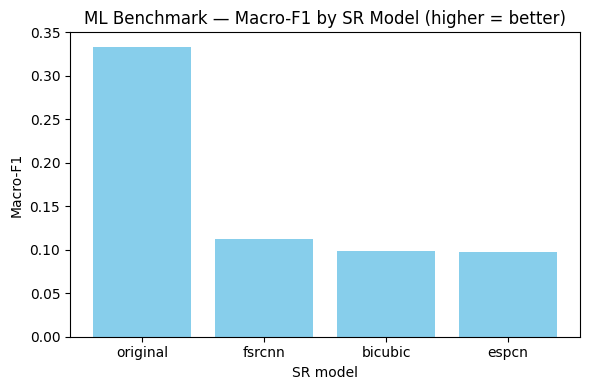

In [ ]:
# === SR → ML BENCHMARK (robust IDRiD matching, Accuracy + Macro-F1) ===
import torch, torchvision, numpy as np, pandas as pd
from pathlib import Path
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from PIL import Image

from src.config.loader import load_cfg
cfg = load_cfg("config.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# SR output dirs
base_dirs = {
    "bicubic":  Path("outputs/sr_images/bicubic_x2"),
    "fsrcnn":   Path("outputs/sr_images/fsrcnn_x2"),
    "espcn":    Path("outputs/sr_images/espcn_x2"),
    "original": Path("outputs/sr_images/original")
}


# ---- LOAD LABELS ----
label_file = Path(cfg.paths.grading_labels)
df = pd.read_csv(label_file)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
df = df.rename(columns={"image_name": "image", "retinopathy_grade": "label"})
df = df[["image", "label"]].dropna().reset_index(drop=True)
df["image"] = df["image"].astype(str).str.replace(".jpg","",regex=False).str.replace(".png","",regex=False)
df["label"] = df["label"].astype(int)
print("Loaded grading labels:", len(df))

# ---- DATASET ----
class FundusDataset(Dataset):
    def __init__(self, root, df, transform):
        self.root = Path(root)
        self.df = df
        self.transform = transform
        self.samples = []
        all_files = {Path(f).stem: f for f in self.root.rglob("*") if f.suffix.lower() in [".jpg",".png",".jpeg",".tif",".tiff"]}
        for _, r in df.iterrows():
            key = str(r["image"]).strip()
            if key in all_files:
                self.samples.append((all_files[key], int(r["label"])))
            else:
                # partial match fallback
                for k in all_files:
                    if k.startswith(key):
                        self.samples.append((all_files[k], int(r["label"])))
                        break
        print(f"[{self.root.name}] Matched {len(self.samples)}/{len(df)} images")

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        p, y = self.samples[idx]
        x = Image.open(p).convert("RGB")
        return self.transform(x), y

# ---- TRANSFORMS ----
tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# ---- MODEL BUILDER ----
def build_model(num_classes):
    m = torchvision.models.resnet18(weights="IMAGENET1K_V1")
    m.fc = torch.nn.Linear(m.fc.in_features, num_classes)
    return m.to(device).eval()

num_classes = len(df["label"].unique())
results = []

# ---- LOOP OVER SR FOLDERS ----
for name, root in base_dirs.items():
    if not root.exists():
        print(f"[WARN] {name} folder missing, skipping.")
        continue

    dataset = FundusDataset(root, df, tfm)
    if len(dataset) == 0:
        print(f"[WARN] No samples matched for {name}, skipping.")
        continue

    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)
    model = build_model(num_classes)

    preds, gts = [], []
    with torch.no_grad(), torch.amp.autocast("cuda", enabled=True):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds.extend(torch.argmax(logits,1).cpu().numpy())
            gts.extend(y.cpu().numpy())

    acc = accuracy_score(gts, preds)
    f1  = f1_score(gts, preds, average="macro")
    results.append({"sr_model": name, "accuracy": acc, "macro_f1": f1})
    print(f"{name.upper():8s} | Accuracy={acc:.4f} | Macro-F1={f1:.4f}")

# ---- RESULTS ----
if results:
    df_res = pd.DataFrame(results).sort_values("macro_f1", ascending=False)
    display(df_res)

    Path("outputs/metrics").mkdir(parents=True, exist_ok=True)
    out_csv = Path("outputs/metrics/ml_benchmark_sr.csv")
    df_res.to_csv(out_csv, index=False)
    print("Saved:", out_csv)

    plt.figure(figsize=(6,4))
    plt.bar(df_res["sr_model"], df_res["macro_f1"], color="skyblue")
    plt.title("ML Benchmark - Macro-F1 by SR Model (higher = better)")
    plt.xlabel("SR model"); plt.ylabel("Macro-F1")
    plt.tight_layout(); plt.show()
else:
    print("No SR results computed — check file naming or paths.")


In [ ]:
# ---------------- Dataset ----------------
root = Path(cfg.paths.grading_images)  
print("Training images source:", root)

class FundusDataset(Dataset):
    def __init__(self, root, df, transform):
        self.root = Path(root)
        all_files = {Path(f).stem: f for f in self.root.rglob("*") if f.suffix.lower() in [".jpg",".png",".jpeg",".tif",".tiff"]}
        self.samples = []
        for _, r in df.iterrows():
            key = str(r["image"]).strip()
            if key in all_files:
                self.samples.append((all_files[key], int(r["label"])))
        self.transform = transform
        print(f"Matched {len(self.samples)}/{len(df)} images")

    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        p, y = self.samples[i]
        x = Image.open(p).convert("RGB")
        return self.transform(x), y


Device: cuda
Using datasets from: C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images
Loaded labels: 413 | Classes: 5


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [14]:
# Tiny training to produce a usable checkpoint quickly (e.g., epochs=2–3)
# Increase cfg.sr.epochs in config.yaml later for stronger SR.
subprocess.run(["python","-m","src.training.train_sr","--config","config.yaml","--model","srcnn"], check=True)

# Confirm checkpoint
Path("outputs/sr_models/srcnn_best.pt").exists()


CalledProcessError: Command '['python', '-m', 'src.training.train_sr', '--config', 'config.yaml', '--model', 'srcnn']' returned non-zero exit status 1.

# 7) Batch export SR (bicubic + srcnn) on Grading images

In [ ]:
# Bicubic is just a baseline writer
subprocess.run([
    "python","-m","src.inference.export_sr",
    "--config","config.yaml","--model","bicubic",
    "--out_dir","outputs/sr_images/bicubic"
], check=True)

# SRCNN uses the fresh checkpoint
subprocess.run([
    "python","-m","src.inference.export_sr",
    "--config","config.yaml","--model","srcnn",
    "--ckpt","outputs/sr_models/srcnn_best.pt",
    "--out_dir","outputs/sr_images/srcnn"
], check=True)


# 8) SR quality metrics on Segmentation subset (PSNR/SSIM + lesion-masked)

In [ ]:
subprocess.run(["python","-m","src.inference.eval_sr_quality","--config","config.yaml"], check=True)

import pandas as pd, glob
for p in sorted(glob.glob("outputs/metrics/sr_eval_*.csv")):
    print(Path(p).name)
    display(pd.read_csv(p).head())


# 9) ZSL evaluation (Original vs SR folders) + comparison plot

In [ ]:
# ===============================================================
# FULL TRAINING SUITE — Original IDRiD Images (Baseline Classifiers)
# ===============================================================
import os, time, torch, torchvision, numpy as np, pandas as pd
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, f1_score
from PIL import Image
from pathlib import Path
from src.config.loader import load_cfg

# ------------------- CONFIG -------------------
cfg = load_cfg("config.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH = 32
EPOCHS = 40          # increase for long runs
LR = 2e-4
WEIGHT_DECAY = 1e-4
OUT_DIR = Path("outputs/sr_models")
LOG_DIR = Path("outputs/metrics/classifier_logs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Device: {device}")
print("Training source:", cfg.paths.grading_images)

# ------------------- LOAD LABELS -------------------
label_file = Path(cfg.paths.grading_labels)
df = pd.read_csv(label_file)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
df = df.rename(columns={"image_name": "image", "retinopathy_grade": "label"})
df = df[["image","label"]].dropna().reset_index(drop=True)
df["image"] = df["image"].astype(str).str.replace(".jpg","",regex=False).str.replace(".png","",regex=False)
df["label"] = df["label"].astype(int)
NUM_CLASSES = len(df["label"].unique())
print(f"Loaded {len(df)} images | Classes: {NUM_CLASSES}")

# ------------------- DATASET -------------------
root = Path(cfg.paths.grading_images)

class FundusDataset(Dataset):
    def __init__(self, root, df, transform):
        self.root = Path(root)
        all_files = {Path(f).stem: f for f in self.root.rglob("*") if f.suffix.lower() in [".jpg",".png",".jpeg",".tif",".tiff"]}
        self.samples = []
        for _, r in df.iterrows():
            key = str(r["image"]).strip()
            if key in all_files:
                self.samples.append((all_files[key], int(r["label"])))
        self.transform = transform
        print(f"Matched {len(self.samples)}/{len(df)} available images.")

    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        p, y = self.samples[i]
        x = Image.open(p).convert("RGB")
        return self.transform(x), y

tfm_train = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
tfm_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

dataset = FundusDataset(root, df, tfm_train)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
val_ds.dataset.transform = tfm_val

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0)

# ------------------- TRAINING LOOP -------------------
def train_model(model_name, builder):
    print(f"\n{'='*60}\n Training {model_name}\n{'='*60}")
    model = builder().to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    loss_fn = torch.nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
    best_acc, log = 0, []

    for ep in range(1, EPOCHS+1):
        t0 = time.time()
        model.train()
        total_loss = 0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=True):
                logits = model(x)
                loss = loss_fn(logits, y)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        # validation
        model.eval()
        preds,gts=[],[]
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                logits = model(x)
                preds.extend(torch.argmax(logits,1).cpu().numpy())
                gts.extend(y.cpu().numpy())
        acc = accuracy_score(gts,preds)
        f1 = f1_score(gts,preds,average="macro")
        log.append([ep,avg_loss,acc,f1])
        print(f"Epoch {ep:02d}/{EPOCHS:02d} | Loss={avg_loss:.4f} | "
              f"Acc={acc:.4f} | F1={f1:.4f} | Time={time.time()-t0:.1f}s")

        # save best
        if acc > best_acc:
            best_acc = acc
            ckpt = OUT_DIR / f"{model_name}_best.pt"
            torch.save(model.state_dict(), ckpt)
            print(f"   Saved best model: {ckpt}")

    # Save log
    log_path = LOG_DIR / f"{model_name}_trainlog.csv"
    pd.DataFrame(log, columns=["epoch","loss","accuracy","macro_f1"]).to_csv(log_path,index=False)
    print(f" Log saved: {log_path}\nBest accuracy: {best_acc:.4f}")
    return model

# ------------------- MODEL BUILDERS -------------------
def build_resnet50():
    m = models.resnet50(weights="IMAGENET1K_V1")
    m.fc = torch.nn.Linear(m.fc.in_features, NUM_CLASSES)
    return m
def build_efficientnet_b3():
    m = models.efficientnet_b3(weights="IMAGENET1K_V1")
    m.classifier[1] = torch.nn.Linear(m.classifier[1].in_features, NUM_CLASSES)
    return m
def build_convnext_tiny():
    m = models.convnext_tiny(weights="IMAGENET1K_V1")
    m.classifier[2] = torch.nn.Linear(m.classifier[2].in_features, NUM_CLASSES)
    return m
def build_vit_b16():
    m = models.vit_b_16(weights="IMAGENET1K_V1")
    m.heads.head = torch.nn.Linear(m.heads.head.in_features, NUM_CLASSES)
    return m

# ------------------- TRAIN ALL -------------------
train_model("resnet50_classifier", build_resnet50)
train_model("efficientnet_b3_classifier", build_efficientnet_b3)
train_model("convnext_tiny_classifier", build_convnext_tiny)
train_model("vit_b16_classifier", build_vit_b16)

print("\n All trainings complete — check /outputs/sr_models/ for best checkpoints.")


Device: cuda
Training source: C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images
Loaded 413 images | Classes: 5
Matched 413/413 available images.

▶ Training resnet50_classifier
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Jonathan Morel/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:17<00:00, 5.81MB/s]
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:89: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 01/40 | Loss=1.3265 | Acc=0.5422 | F1=0.3819 | Time=26.9s
  ↳ Saved best model: outputs\sr_models\resnet50_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 02/40 | Loss=0.8474 | Acc=0.5181 | F1=0.3123 | Time=23.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 03/40 | Loss=0.3889 | Acc=0.4699 | F1=0.2921 | Time=23.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 04/40 | Loss=0.2176 | Acc=0.4699 | F1=0.2915 | Time=23.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 05/40 | Loss=0.1664 | Acc=0.4819 | F1=0.3303 | Time=23.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 06/40 | Loss=0.1744 | Acc=0.4940 | F1=0.2962 | Time=22.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 07/40 | Loss=0.1957 | Acc=0.4819 | F1=0.3413 | Time=22.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 08/40 | Loss=0.3593 | Acc=0.5422 | F1=0.4353 | Time=23.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 09/40 | Loss=0.2743 | Acc=0.5060 | F1=0.3693 | Time=23.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 10/40 | Loss=0.2010 | Acc=0.5301 | F1=0.3754 | Time=23.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 11/40 | Loss=0.1368 | Acc=0.4819 | F1=0.3188 | Time=22.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 12/40 | Loss=0.0861 | Acc=0.4819 | F1=0.3039 | Time=22.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 13/40 | Loss=0.0797 | Acc=0.5181 | F1=0.3393 | Time=22.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 14/40 | Loss=0.0278 | Acc=0.4458 | F1=0.2860 | Time=22.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 15/40 | Loss=0.0172 | Acc=0.5422 | F1=0.4038 | Time=22.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 16/40 | Loss=0.0193 | Acc=0.5542 | F1=0.4031 | Time=23.9s
  ↳ Saved best model: outputs\sr_models\resnet50_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 17/40 | Loss=0.0167 | Acc=0.5542 | F1=0.3670 | Time=25.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 18/40 | Loss=0.0234 | Acc=0.5301 | F1=0.3558 | Time=25.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 19/40 | Loss=0.0816 | Acc=0.4819 | F1=0.3316 | Time=25.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 20/40 | Loss=0.1023 | Acc=0.5422 | F1=0.3386 | Time=25.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 21/40 | Loss=0.0740 | Acc=0.5060 | F1=0.3806 | Time=25.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 22/40 | Loss=0.0441 | Acc=0.5783 | F1=0.4338 | Time=25.3s
  ↳ Saved best model: outputs\sr_models\resnet50_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 23/40 | Loss=0.0374 | Acc=0.5542 | F1=0.3813 | Time=25.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 24/40 | Loss=0.0669 | Acc=0.4458 | F1=0.2959 | Time=25.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 25/40 | Loss=0.1440 | Acc=0.5181 | F1=0.3999 | Time=25.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 26/40 | Loss=0.0857 | Acc=0.5301 | F1=0.3636 | Time=25.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 27/40 | Loss=0.0748 | Acc=0.5060 | F1=0.3494 | Time=25.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 28/40 | Loss=0.0396 | Acc=0.4940 | F1=0.3322 | Time=25.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 29/40 | Loss=0.0214 | Acc=0.5060 | F1=0.3798 | Time=25.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 30/40 | Loss=0.0466 | Acc=0.5422 | F1=0.3938 | Time=25.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 31/40 | Loss=0.0398 | Acc=0.5060 | F1=0.3764 | Time=25.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 32/40 | Loss=0.0224 | Acc=0.4940 | F1=0.3353 | Time=25.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 33/40 | Loss=0.0259 | Acc=0.5181 | F1=0.3536 | Time=25.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 34/40 | Loss=0.0108 | Acc=0.4699 | F1=0.3227 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 35/40 | Loss=0.0233 | Acc=0.4819 | F1=0.3348 | Time=25.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 36/40 | Loss=0.0772 | Acc=0.4819 | F1=0.3087 | Time=25.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 37/40 | Loss=0.1473 | Acc=0.3735 | F1=0.3280 | Time=25.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 38/40 | Loss=0.1403 | Acc=0.5663 | F1=0.4119 | Time=25.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 39/40 | Loss=0.0841 | Acc=0.4699 | F1=0.3121 | Time=25.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 40/40 | Loss=0.0931 | Acc=0.5060 | F1=0.3527 | Time=25.3s
📈 Log saved: outputs\metrics\classifier_logs\resnet50_classifier_trainlog.csv
Best accuracy: 0.5783

▶ Training efficientnet_b3_classifier
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\Jonathan Morel/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:07<00:00, 6.45MB/s]
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:89: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 01/40 | Loss=1.5165 | Acc=0.4337 | F1=0.2255 | Time=43.3s
  ↳ Saved best model: outputs\sr_models\efficientnet_b3_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 02/40 | Loss=1.2500 | Acc=0.4337 | F1=0.1938 | Time=25.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 03/40 | Loss=1.0503 | Acc=0.4217 | F1=0.2173 | Time=25.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 04/40 | Loss=0.8044 | Acc=0.5422 | F1=0.3392 | Time=25.5s
  ↳ Saved best model: outputs\sr_models\efficientnet_b3_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 05/40 | Loss=0.6583 | Acc=0.5663 | F1=0.3476 | Time=25.7s
  ↳ Saved best model: outputs\sr_models\efficientnet_b3_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 06/40 | Loss=0.4993 | Acc=0.4940 | F1=0.3390 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 07/40 | Loss=0.3709 | Acc=0.5301 | F1=0.3334 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 08/40 | Loss=0.2431 | Acc=0.5542 | F1=0.4073 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 09/40 | Loss=0.2002 | Acc=0.5422 | F1=0.4190 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 10/40 | Loss=0.1673 | Acc=0.5301 | F1=0.3890 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 11/40 | Loss=0.1343 | Acc=0.5542 | F1=0.3972 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 12/40 | Loss=0.1205 | Acc=0.5422 | F1=0.3537 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 13/40 | Loss=0.0701 | Acc=0.5181 | F1=0.3507 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 14/40 | Loss=0.0866 | Acc=0.4940 | F1=0.3923 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 15/40 | Loss=0.0382 | Acc=0.4940 | F1=0.3475 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 16/40 | Loss=0.0548 | Acc=0.4940 | F1=0.3456 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 17/40 | Loss=0.0356 | Acc=0.5060 | F1=0.3777 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 18/40 | Loss=0.0355 | Acc=0.5060 | F1=0.3515 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 19/40 | Loss=0.0426 | Acc=0.5301 | F1=0.4160 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 20/40 | Loss=0.0667 | Acc=0.5663 | F1=0.4279 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 21/40 | Loss=0.0388 | Acc=0.5663 | F1=0.4691 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 22/40 | Loss=0.0318 | Acc=0.5663 | F1=0.4345 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 23/40 | Loss=0.0239 | Acc=0.5542 | F1=0.4670 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 24/40 | Loss=0.0189 | Acc=0.5060 | F1=0.3468 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 25/40 | Loss=0.0318 | Acc=0.4819 | F1=0.3350 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 26/40 | Loss=0.0170 | Acc=0.4699 | F1=0.2982 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 27/40 | Loss=0.0278 | Acc=0.4578 | F1=0.3290 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 28/40 | Loss=0.0556 | Acc=0.4578 | F1=0.3448 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 29/40 | Loss=0.0860 | Acc=0.5301 | F1=0.4009 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 30/40 | Loss=0.0279 | Acc=0.5422 | F1=0.4061 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 31/40 | Loss=0.0388 | Acc=0.5783 | F1=0.4925 | Time=25.7s
  ↳ Saved best model: outputs\sr_models\efficientnet_b3_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 32/40 | Loss=0.0192 | Acc=0.5181 | F1=0.3857 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 33/40 | Loss=0.0692 | Acc=0.5060 | F1=0.3669 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 34/40 | Loss=0.0258 | Acc=0.5181 | F1=0.3593 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 35/40 | Loss=0.0572 | Acc=0.5422 | F1=0.3998 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 36/40 | Loss=0.0633 | Acc=0.5422 | F1=0.4097 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 37/40 | Loss=0.0376 | Acc=0.5181 | F1=0.3703 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 38/40 | Loss=0.0316 | Acc=0.5422 | F1=0.3785 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 39/40 | Loss=0.0411 | Acc=0.6145 | F1=0.4584 | Time=25.8s
  ↳ Saved best model: outputs\sr_models\efficientnet_b3_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 40/40 | Loss=0.0231 | Acc=0.6024 | F1=0.4664 | Time=25.8s
📈 Log saved: outputs\metrics\classifier_logs\efficientnet_b3_classifier_trainlog.csv
Best accuracy: 0.6145

▶ Training convnext_tiny_classifier
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\Jonathan Morel/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:19<00:00, 6.02MB/s] 
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:89: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 01/40 | Loss=1.3833 | Acc=0.4578 | F1=0.2265 | Time=41.9s
  ↳ Saved best model: outputs\sr_models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 02/40 | Loss=1.1797 | Acc=0.4699 | F1=0.2703 | Time=25.7s
  ↳ Saved best model: outputs\sr_models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 03/40 | Loss=1.0170 | Acc=0.4940 | F1=0.3117 | Time=25.6s
  ↳ Saved best model: outputs\sr_models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 04/40 | Loss=0.8698 | Acc=0.5301 | F1=0.2802 | Time=25.7s
  ↳ Saved best model: outputs\sr_models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 05/40 | Loss=0.6874 | Acc=0.5301 | F1=0.3575 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 06/40 | Loss=0.3867 | Acc=0.5422 | F1=0.4200 | Time=25.6s
  ↳ Saved best model: outputs\sr_models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 07/40 | Loss=0.1632 | Acc=0.5422 | F1=0.4246 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 08/40 | Loss=0.0514 | Acc=0.5181 | F1=0.3680 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 09/40 | Loss=0.0351 | Acc=0.5301 | F1=0.3317 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 10/40 | Loss=0.0300 | Acc=0.5783 | F1=0.4998 | Time=25.6s
  ↳ Saved best model: outputs\sr_models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 11/40 | Loss=0.0356 | Acc=0.4940 | F1=0.2922 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 12/40 | Loss=0.0715 | Acc=0.5060 | F1=0.4012 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 13/40 | Loss=0.0424 | Acc=0.3133 | F1=0.3324 | Time=25.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 14/40 | Loss=0.0954 | Acc=0.5542 | F1=0.4160 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 15/40 | Loss=0.0526 | Acc=0.4819 | F1=0.3474 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 16/40 | Loss=0.1403 | Acc=0.4578 | F1=0.3699 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 17/40 | Loss=0.0814 | Acc=0.5301 | F1=0.3927 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 18/40 | Loss=0.4216 | Acc=0.4819 | F1=0.2850 | Time=25.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 19/40 | Loss=0.1432 | Acc=0.5060 | F1=0.3199 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 20/40 | Loss=0.0783 | Acc=0.5301 | F1=0.3373 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 21/40 | Loss=0.0428 | Acc=0.3976 | F1=0.3176 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 22/40 | Loss=0.0167 | Acc=0.5060 | F1=0.3000 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 23/40 | Loss=0.0195 | Acc=0.5301 | F1=0.3840 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 24/40 | Loss=0.0092 | Acc=0.5301 | F1=0.3996 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 25/40 | Loss=0.0112 | Acc=0.5181 | F1=0.3297 | Time=25.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 26/40 | Loss=0.0155 | Acc=0.5422 | F1=0.3553 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 27/40 | Loss=0.0021 | Acc=0.5181 | F1=0.4358 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 28/40 | Loss=0.0044 | Acc=0.4940 | F1=0.3927 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 29/40 | Loss=0.0056 | Acc=0.5422 | F1=0.3789 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 30/40 | Loss=0.0033 | Acc=0.5181 | F1=0.3555 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 31/40 | Loss=0.0017 | Acc=0.5181 | F1=0.3369 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 32/40 | Loss=0.0008 | Acc=0.5301 | F1=0.3445 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 33/40 | Loss=0.0011 | Acc=0.5301 | F1=0.3559 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 34/40 | Loss=0.0028 | Acc=0.5181 | F1=0.3353 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 35/40 | Loss=0.0049 | Acc=0.4458 | F1=0.3420 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 36/40 | Loss=0.0351 | Acc=0.5663 | F1=0.3536 | Time=25.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 37/40 | Loss=0.0512 | Acc=0.5663 | F1=0.3679 | Time=25.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 38/40 | Loss=0.1171 | Acc=0.5181 | F1=0.3530 | Time=25.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 39/40 | Loss=0.1230 | Acc=0.6265 | F1=0.4150 | Time=25.5s
  ↳ Saved best model: outputs\sr_models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 40/40 | Loss=0.0528 | Acc=0.4940 | F1=0.3337 | Time=25.6s
📈 Log saved: outputs\metrics\classifier_logs\convnext_tiny_classifier_trainlog.csv
Best accuracy: 0.6265

▶ Training vit_b16_classifier
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\Jonathan Morel/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth


100%|██████████| 330M/330M [01:00<00:00, 5.71MB/s] 
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:89: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 01/40 | Loss=1.6402 | Acc=0.3133 | F1=0.0954 | Time=29.0s
  ↳ Saved best model: outputs\sr_models\vit_b16_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 02/40 | Loss=1.4802 | Acc=0.3133 | F1=0.0954 | Time=26.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 03/40 | Loss=1.4479 | Acc=0.3735 | F1=0.1088 | Time=26.0s
  ↳ Saved best model: outputs\sr_models\vit_b16_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 04/40 | Loss=1.4688 | Acc=0.3735 | F1=0.1763 | Time=25.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 05/40 | Loss=1.3952 | Acc=0.5060 | F1=0.2407 | Time=25.9s
  ↳ Saved best model: outputs\sr_models\vit_b16_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 06/40 | Loss=1.4013 | Acc=0.3133 | F1=0.1056 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 07/40 | Loss=1.4041 | Acc=0.4940 | F1=0.2262 | Time=26.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 08/40 | Loss=1.3574 | Acc=0.4337 | F1=0.2108 | Time=25.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 09/40 | Loss=1.3784 | Acc=0.4337 | F1=0.2108 | Time=26.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 10/40 | Loss=1.3246 | Acc=0.5060 | F1=0.2375 | Time=25.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 11/40 | Loss=1.3633 | Acc=0.4217 | F1=0.2058 | Time=25.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 12/40 | Loss=1.3846 | Acc=0.4578 | F1=0.2177 | Time=25.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 13/40 | Loss=1.3491 | Acc=0.4578 | F1=0.2237 | Time=26.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 14/40 | Loss=1.3178 | Acc=0.4699 | F1=0.2222 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 15/40 | Loss=1.2753 | Acc=0.4940 | F1=0.2275 | Time=25.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 16/40 | Loss=1.2829 | Acc=0.4940 | F1=0.2267 | Time=26.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 17/40 | Loss=1.2940 | Acc=0.4458 | F1=0.2410 | Time=26.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 18/40 | Loss=1.2765 | Acc=0.5181 | F1=0.2450 | Time=25.9s
  ↳ Saved best model: outputs\sr_models\vit_b16_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 19/40 | Loss=1.2589 | Acc=0.4940 | F1=0.2330 | Time=26.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 20/40 | Loss=1.2729 | Acc=0.4940 | F1=0.2320 | Time=25.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 21/40 | Loss=1.2858 | Acc=0.5060 | F1=0.2355 | Time=26.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 22/40 | Loss=1.2057 | Acc=0.5181 | F1=0.2449 | Time=26.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 23/40 | Loss=1.2029 | Acc=0.5060 | F1=0.2414 | Time=26.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 24/40 | Loss=1.2378 | Acc=0.3855 | F1=0.2110 | Time=26.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 25/40 | Loss=1.1847 | Acc=0.4819 | F1=0.2791 | Time=26.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 26/40 | Loss=1.1679 | Acc=0.4337 | F1=0.2400 | Time=26.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 27/40 | Loss=1.2418 | Acc=0.3855 | F1=0.2527 | Time=26.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 28/40 | Loss=1.2356 | Acc=0.4578 | F1=0.2280 | Time=25.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 29/40 | Loss=1.1893 | Acc=0.4699 | F1=0.2279 | Time=25.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 30/40 | Loss=1.1819 | Acc=0.4217 | F1=0.3285 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 31/40 | Loss=1.1976 | Acc=0.4699 | F1=0.2187 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 32/40 | Loss=1.0940 | Acc=0.4217 | F1=0.2506 | Time=25.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 33/40 | Loss=1.0388 | Acc=0.4458 | F1=0.2078 | Time=25.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 34/40 | Loss=1.0439 | Acc=0.4819 | F1=0.2374 | Time=25.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 35/40 | Loss=1.1192 | Acc=0.4337 | F1=0.2830 | Time=26.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 36/40 | Loss=1.1496 | Acc=0.4096 | F1=0.2334 | Time=26.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 37/40 | Loss=0.9629 | Acc=0.3855 | F1=0.2746 | Time=26.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 38/40 | Loss=0.9778 | Acc=0.2771 | F1=0.1827 | Time=26.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 39/40 | Loss=1.3071 | Acc=0.4578 | F1=0.2192 | Time=26.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_25240\3331357912.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 40/40 | Loss=1.2301 | Acc=0.4578 | F1=0.2712 | Time=26.1s
📈 Log saved: outputs\metrics\classifier_logs\vit_b16_classifier_trainlog.csv
Best accuracy: 0.5181

✅ All trainings complete — check /outputs/sr_models/ for best checkpoints.
